# LSTM으로 지문을 읽어서 주제를 분류하기

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

In [1]:
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

# 항상 같은 결과를 갖기 위해 랜덤 시드 설정
tf.random.set_seed(1)
np.random.seed(1)

LSTM을 사용하여 각 지문의 주제를 분류하는 예제를 다뤄보겠습니다.  
아래 실습을 위해 입력값을 팬더스 데이터프레임에 저장합니다.

In [2]:
paragraph_dict_list = [
         {'paragraph': 'dishplace is located in sunnyvale downtown there is parking around the area but it can be difficult to find during peak business hours my sisters and i came to this place for dinner on a weekday they were really busy so i highly recommended making reservations unless you have the patience to wait', 'category': 'food'},
         {'paragraph': 'service can be slower during busy hours but our waiter was courteous and help gave some great entree recommendations', 'category': 'food'},
         {'paragraph': 'portions are huge both french toast and their various omelettes are really good their french toast is probably 1.5x more than other brunch places great place to visit if you are hungry and dont want to wait 1 hour for a table', 'category': 'food'},
         {'paragraph': 'we started with apps going the chicken and waffle slides and chicken nachos the sliders were amazing and the nachos were good too maybe by themselves the nachos would have scored better but after those sliders they were up against some tough competition', 'category': 'food'},
         {'paragraph': 'the biscuits and gravy was too salty two people in my group had the gravy and all thought it was too salty my hubby ordered a side of double egg and it was served on two small plates who serves eggs to one person on separate plates we commented on that when it was delivered and even the server laughed and said she doesnt know why the kitchen does that presentation of food is important and they really missed on this one', 'category': 'food'},
         {'paragraph': 'the garlic fries were a great starter (and a happy hour special) the pancakes looked and tasted great and were a fairly generous portion', 'category': 'food'},
         {'paragraph': 'our meal was excellent i had the pasta ai formaggi which was so rich i didnt dare eat it all although i certainly wanted to excellent flavors with a great texture contrast between the soft pasta and the crisp bread crumbs too much sauce for me but a wonderful dish', 'category': 'food'},
         {'paragraph': 'what i enjoy most about palo alto is so many restaurants have dog-friendly seating outside i had bookmarked italico from when they first opened about a 1.5 years ago and was jonesing for some pasta so time to finally knock that bookmark off', 'category': 'food'},
         {'paragraph': 'the drinks came out fairly quickly a good two to three minutes after the orders were taken i expected my iced tea to taste a bit more sweet but this was straight up green tea with ice in it not to complain of course but i was pleasantly surprised', 'category': 'food'},
         {'paragraph': 'despite the not so good burger the service was so slow the restaurant wasnt even half full and they took very long from the moment we got seated to the time we left it was almost 2 hours we thought that it would be quick since we ordered as soon as we sat down my coworkers did seem to enjoy their beef burgers for those who eat beef however i will not be returning it is too expensive and extremely slow service', 'category': 'food'},
    
         {'paragraph': 'the four reigning major champions simona halep caroline wozniacki angelique kerber and defending us open champion sloane stephens could make a case for being the quartet most likely to succeed especially as all but stephens has also enjoyed the no1 ranking within the last 14 months as they prepare for their gruelling new york campaigns they currently hold the top four places in the ranks', 'category': 'sports'},
         {'paragraph': 'the briton was seeded nn7 here last year before a slump in form and confidence took her down to no46 after five first-round losses but there have been signs of a turnaround including a victory over a sub-par serena williams in san jose plus wins against jelena ostapenko and victoria azarenka in montreal. konta pulled out of new haven this week with illness but will hope for good things where she first scored wins in a major before her big breakthroughs to the semis in australia and wimbledon', 'category': 'sports'},
         {'paragraph': 'stephens surged her way back from injury in stunning style to win her first major here last year—and ranked just no83 she has since proved what a big time player she is winning the miami title via four fellow major champions then reaching the final at the french open back on north american hard courts she ran to the final in montreal only just edged out by halep she has also avoided many of the big names in her quarter—except for wild card azarenka as a possible in the third round', 'category': 'sports'},
         {'paragraph': 'when it came to england chances in the world cup it would be fair to say that most fans had never been more pessimistic than they were this year after enduring years of truly dismal performances at major tournaments – culminating in the 2014 event where they failed to win any of their three group games and finished in bottom spot those results led to the resignation of manager roy hodgson', 'category': 'sports'},
         {'paragraph': 'the team that eliminated russia – croatia – also improved enormously during the tournament before it began their odds were 33/1 but they played with real flair and star players like luka modric ivan rakitic and ivan perisic showed their quality on the world stage having displayed their potential by winning all three of their group stage games croatia went on to face difficult tests like the semi-final against england', 'category': 'sports'},
         {'paragraph': 'the perseyside outfit finished in fourth place in the premier league table and without a trophy last term after having reached the champions league final before losing to real madrid', 'category': 'sports'},
         {'paragraph': 'liverpool fc will return to premier league action on saturday lunchtime when they travel to leicester city in the top flight as they look to make it four wins in a row in the league', 'category': 'sports'},
         {'paragraph': 'alisson signed for liverpool fc from as roma this summer and the brazilian goalkeeper has helped the reds to keep three clean sheets in their first three premier league games', 'category': 'sports'},
         {'paragraph': 'but the rankings during that run-in to new york hid some very different undercurrents for murray had struggled with a hip injury since the clay swing and had not played a match since losing his quarter-final at wimbledon and he would pull out of the us open just two days before the tournament began—too late however to promote nederer to the no2 seeding', 'category': 'sports'},
         {'paragraph': 'then came the oh-so-familiar djokovic-nadal no-quarter-given battle for dominance in the third set there were exhilarating rallies with both chasing to the net both retrieving what looked like winning shots nadal more than once pulled off a reverse smash and had his chance to seal the tie-break but it was djokovic serving at 10-9 who dragged one decisive error from nadal for a two-sets lead', 'category': 'sports'}
]
df = pd.DataFrame(paragraph_dict_list)
df = df[['paragraph', 'category']]

주제가 **음식**인 지문을 몇개 출력해보도록 하겠습니다.

In [3]:
df.head()

,paragraph,category
0,dishplace is located in sunnyvale downtown the...,food
1,service can be slower during busy hours but ou...,food
2,portions are huge both french toast and their ...,food
3,we started with apps going the chicken and waf...,food
4,the biscuits and gravy was too salty two peopl...,food


주제가 **스포츠**인 지문을 몇개 출력해보도록 하겠습니다.

In [4]:
df.tail()

,paragraph,category
15,the perseyside outfit finished in fourth place...,sports
16,liverpool fc will return to premier league act...,sports
17,alisson signed for liverpool fc from as roma t...,sports
18,but the rankings during that run-in to new yor...,sports
19,then came the oh-so-familiar djokovic-nadal no...,sports


# 데이터 전처리
모든 딥러닝 모델들이 수학에 근간하듯이, LSTM 역시 수학을 기반으로한 모델이므로, 입력값을 수치값으로 변경해주어야 합니다.

In [5]:
def get_vocab_size(df):
    """
    데이터에 사용된 중복 없는 전체 단어 갯수를 리턴합니다.
    """
    results = set()
    df['paragraph'].str.lower().str.split().apply(results.update)
    return len(results)

In [6]:
# 전체 단어 갯수
vocab_size = get_vocab_size(df)

In [7]:
# 단어를 숫자로 인코딩합니다.
paragraphs = df['paragraph'].tolist()
encoded_paragraphs = [one_hot(paragraph, vocab_size) for paragraph in paragraphs]

In [8]:
def get_max_length(df):
    """
    데이터에서 가장 긴 문장의 단어 갯수를 리턴합니다.
    """
    max_length = 0
    for row in df['paragraph']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length
        
max_length = get_max_length(df)
print (max_length)

91


In [9]:
# 문장마다 단어갯수가 다르므로, 
# 제로 패딩을 넣어줘서 문장의 길이를 동일하게 만듭니다.

padded_paragraphs_encoding = pad_sequences(encoded_paragraphs, 
                                           maxlen=max_length, 
                                           padding='post')

In [14]:
padded_paragraphs_encoding

array([[ 46, 452, 260, ...,   0,   0,   0],
       [113, 468, 249, ...,   0,   0,   0],
       [460,  83, 276, ...,   0,   0,   0],
       ...,
       [ 23, 428, 347, ...,   0,   0,   0],
       [307, 372,  58, ...,   0,   0,   0],
       [ 28, 428, 372, ...,   0,   0,   0]], dtype=int32)

In [17]:
categories = df['category'].tolist()
def category_encode(category):
    """
    분류 항목(food, sports) 역시 수치로 변경해야합니다. 
    분류 항목은 one hot encoding으로 변경합니다.
    """
    if category == 'food':
        return [1,0]
    else:
        return [0,1]
encoded_category = [category_encode(category) for category in categories]

In [18]:
# 원 핫 인코딩 예시
print(encoded_paragraphs[0])
print(encoded_paragraphs[19])

[46, 452, 260, 149, 473, 198, 186, 452, 247, 66, 372, 420, 307, 184, 468, 249, 129, 516, 457, 208, 477, 428, 343, 423, 111, 141, 286, 428, 516, 371, 99, 347, 371, 37, 108, 331, 251, 318, 436, 126, 34, 286, 85, 331, 355, 118, 198, 196, 207, 372, 228, 516, 102]
[28, 428, 372, 157, 34, 165, 25, 473, 317, 98, 78, 343, 347, 229, 149, 372, 160, 504, 186, 318, 311, 78, 78, 244, 386, 516, 372, 142, 244, 189, 370, 362, 161, 220, 406, 473, 187, 42, 237, 384, 431, 108, 406, 477, 141, 504, 175, 372, 516, 165, 372, 194, 174, 307, 184, 442, 25, 38, 503, 86, 412, 269, 498, 477, 88, 343, 209, 473, 347, 108, 213, 261, 160]


# 텐서플로우로 지문을 읽고 주제를 분류하는 모델 구현하기

아래 다이어그램 그대로 텐서플로우 모델을 구현해보도록 하겠습니다.

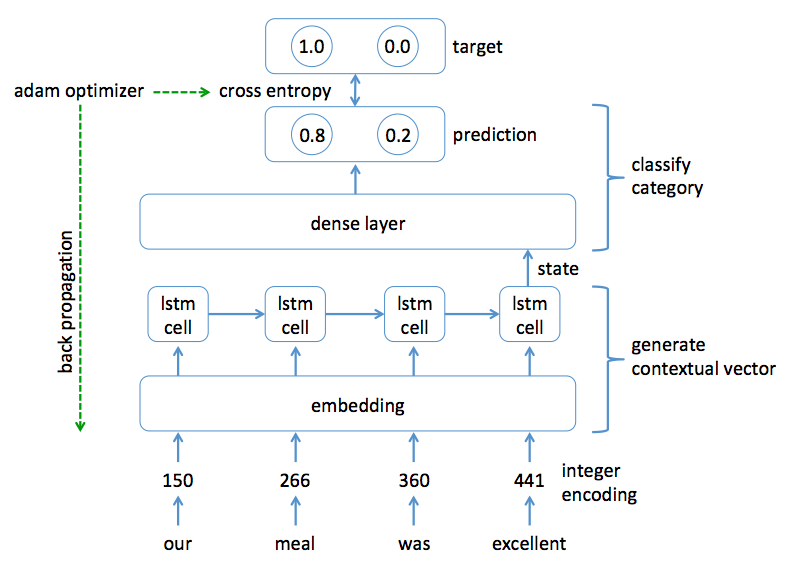

In [4]:
Image("lstm_model_overview.png", width=500, height=250)

In [20]:
model = Sequential()
model.add(Embedding(vocab_size, 5, input_length=max_length))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
train_X = np.array(padded_paragraphs_encoding)
train_Y = np.array(encoded_category)

In [23]:
print('Train...')
model.fit(train_X, train_Y,batch_size=10,epochs=50)

Train...
Train on 20 samples
Epoch 1/50
20/20 [==============================] - 2s 116ms/sample - loss: 0.6947 - accuracy: 0.4000
Epoch 2/50
20/20 [==============================] - 0s 5ms/sample - loss: 0.6937 - accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 0s 4ms/sample - loss: 0.6929 - accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 0s 5ms/sample - loss: 0.6927 - accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 0s 6ms/sample - loss: 0.6923 - accuracy: 0.5000
Epoch 6/50
20/20 [==============================] - 0s 5ms/sample - loss: 0.6919 - accuracy: 0.4500
Epoch 7/50
20/20 [==============================] - 0s 5ms/sample - loss: 0.6916 - accuracy: 0.5000
Epoch 8/50
20/20 [==============================] - 0s 7ms/sample - loss: 0.6909 - accuracy: 0.6000
Epoch 9/50
20/20 [==============================] - 0s 6ms/sample - loss: 0.6903 - accuracy: 0.6000
Epoch 10/50
20/20 [==============================] - 0s 7ms/sample - 

In [24]:
score, acc = model.evaluate(train_X, train_Y, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

20/1 - 1s - loss: 6.6217e-04 - accuracy: 1.0000
Test score: 0.0006621706997975707
Test accuracy: 1.0


모든 지문들이 충분히 학습되어, 학습 정확도가 100%인 것을 확인할 수 있습니다.

# 모델 요약
모델에 대한 간략한 요약은 다음과 같습니다.  
[문맥 벡터 생성]  
입력값은 단어들의 인덱스이며, 그 길이는 항상 91입니다.  
임베딩 레이어는 인덱스를 받아, 5차원 벡터의 임베딩을 출력합니다.  
LSTM 셀은 64차원 벡터의 상태값을 출력합니다.  

[문맥 벡터를 사용하여 지문의 주제 분류하기]  
주제 분류는 두개의 dense layer를 사용합니다.  
첫번째 dense layer는 32개의 노드를 가지고 있습니다.  
두번째 dense layer는 2개의 노드를 가지고 있으며, 이 2개의 노드는 소프트맥스의 입력값으로 들어갑니다.  
소프트맥스는 각 분류값에 해당할 확률을 출력합니다.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 91, 5)             2680      
_________________________________________________________________
lstm (LSTM)                  (None, 64)                17920     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 22,746
Trainable params: 22,746
Non-trainable params: 0
_________________________________________________________________


# 참고자료
arXiv:1708.00107 [cs.CL]  [https://arxiv.org/abs/1708.00107]  
Learned in Translation: Contextualized Word Vectors  
Bryan McCann, James Bradbury, Caiming Xiong, Richard Socher